## Проектирование признаков

Создание признаков, feature extraction, часто именуемое генерацией признаков, — творческий процесс извлечения новых признаков путём создания признаков из существующего набора данных или путём использования дополнительной информации. 

Проектирование признаков необходимо для улучшения качества будущей модели: в процессе создания признаков появляются новые, возможно, более качественные, чем исходные.

Новые признаки могут быть сконструированы двумя способами: 
1. с помощью внешних источников данных;
2. из существующего набора данных.

Новые признаки можно сконструировать из уже существующего набора данных несколькими способами: 
* разбор категорий; 
* разбор даты и времени;
* разбор числовых признаков;
* разбор текста.

In [143]:
import pandas as pd

data = pd.read_csv('wine_cleared.csv') # чтение очищенных данных

РАЗБОР ЧИСЛОВЫХ ВЕЛИЧИН

In [144]:
# для удобства сразу преобразуем признак в int
data['price_round'] = data['price'].round().astype(int)

РАЗБОР ТЕКСТА

Для того, чтобы извлечь из строки число, обозначающее год, необходимо воспользоваться регулярными выражениями.

Регулярные выражения (regexp, или regex) — это механизм для поиска и замены текста. Это шаблоны, которые используются для поиска соответствующей части текста.

Например, с помощью такого регулярного выражения [^@ \t\r\n]+@[^@ \t\r\n]+\.[^@ \t\r\n]+ можно найти любой email в тексте.

In [145]:
regex = '\d+' # регулярное выражение для нахождения чисел
data['year'] = data['title'].str.findall(regex).str.get(0)

In [146]:
regex = '\((.*?)\)' # регулярное выражение для нахождения региона
data['locality'] = data['title'].str.findall(regex).str.get(0)

РАЗБОР КАТЕГОРИЙ

In [147]:
data['is_usa'] = data['country'].apply(lambda x: 1 if x == 'US' else 0)
data['is_france'] = data['country'].apply(lambda x: 1 if x == 'France' else 0)
data['is_italy'] = data['country'].apply(lambda x: 1 if x == 'Italy' else 0)

In [148]:
data['is_italy'].sum()

19540

РАБОТА С ФАЙЛАМИ

In [149]:
country_population = pd.read_csv('country_population.csv', sep=';')
country_area = pd.read_csv('country_area.csv', sep=';')

data = data.join(country_population.set_index('country'), on='country')
data = data.join(country_area.set_index('country'), on='country')

In [150]:
# преобразуем признак year в объект datetime для удобного сравнения дат
data['year'] = pd.to_datetime(data['year'], errors='coerce')

# для сравнения используем год, заполняем значения признака old_wine, где год вина меньше 2010
data['old_wine'] = data['year'].apply(lambda x: 1 if x.year < 2010 else 0) 
data['old_wine'].sum()

39595

In [151]:
# Создание признаков

data['year'] = pd.to_datetime(data['year'])
data['today'] = '2022-01-12 00:00:00'
data['today'] = pd.to_datetime(data['today'])

data['years_diff'] = (data['today'] - data['year']).dt.days
data = data.drop(columns=['today'], axis=1)
data['years_diff'].max()

98627.0

In [152]:
# Кодирование признаков
import category_encoders as ce

ord_encoder = ce.OrdinalEncoder(cols=['year'])
year_col = ord_encoder.fit_transform(data['year'])
data = pd.concat([data, year_col], axis=1)

In [153]:
# однократное кодирование
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['taster_name'])
type_bin = encoder.fit_transform(data['taster_name'])
data = pd.concat([data, type_bin], axis=1)

In [154]:
# двоичное кодирование
import category_encoders as ce 

bin_encoder = ce.BinaryEncoder(cols=['country']) 
type_bin = bin_encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

In [155]:
# data['taster_twitter_handle'].nunique()
# 16

bin_encoder = ce.BinaryEncoder(cols=['taster_twitter_handle']) 
type_bin = bin_encoder.fit_transform(data['taster_twitter_handle'])
data = pd.concat([data, type_bin], axis=1)

In [156]:
# Нормализуйте признак price. Используйте подходящий тип нормализации.
from sklearn import preprocessing

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
df_r = r_scaler.fit_transform(data[['price']])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
col_names = list(data[['price']].columns)
df_r = pd.DataFrame(df_r, columns=col_names)

df_r['price'].sum()

43500.77493697044

In [157]:
# Стандартизируйте исходный признак price.
from sklearn import preprocessing

# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# копируем исходный датасет
df_s = s_scaler.fit_transform(data[['price']])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
col_names = list(data[['price']].columns)
df_s = pd.DataFrame(df_s, columns=col_names)

df_s['price'][129968]

1.001514868120814

<AxesSubplot:>

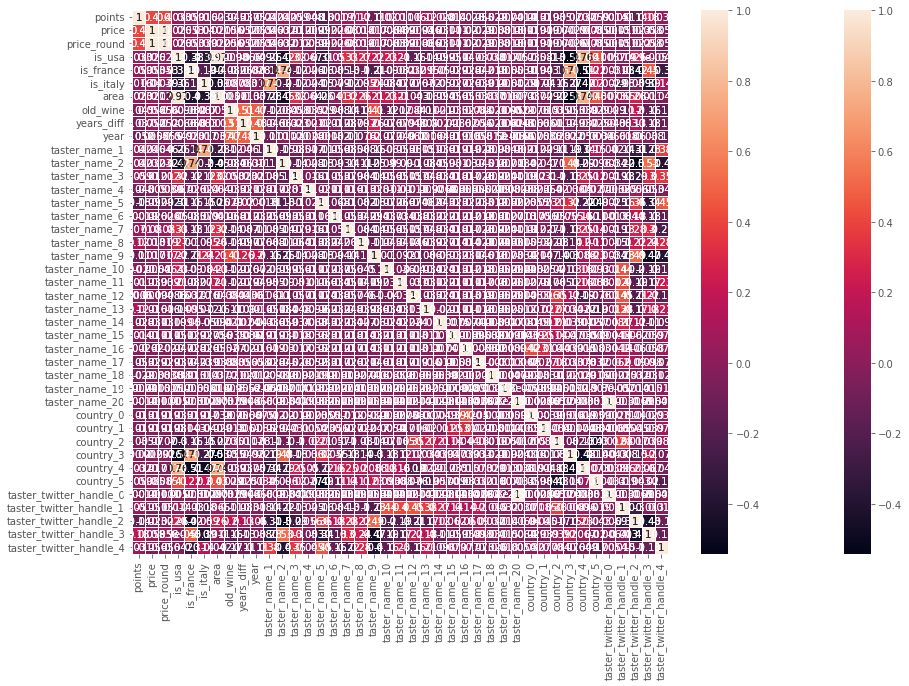

In [158]:
# Отбор признаков 
# Построим график корреляции всех величин. Для простоты воспользуемся корреляцией Пирсона.

# работа с визуализацией
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax)

<AxesSubplot:>

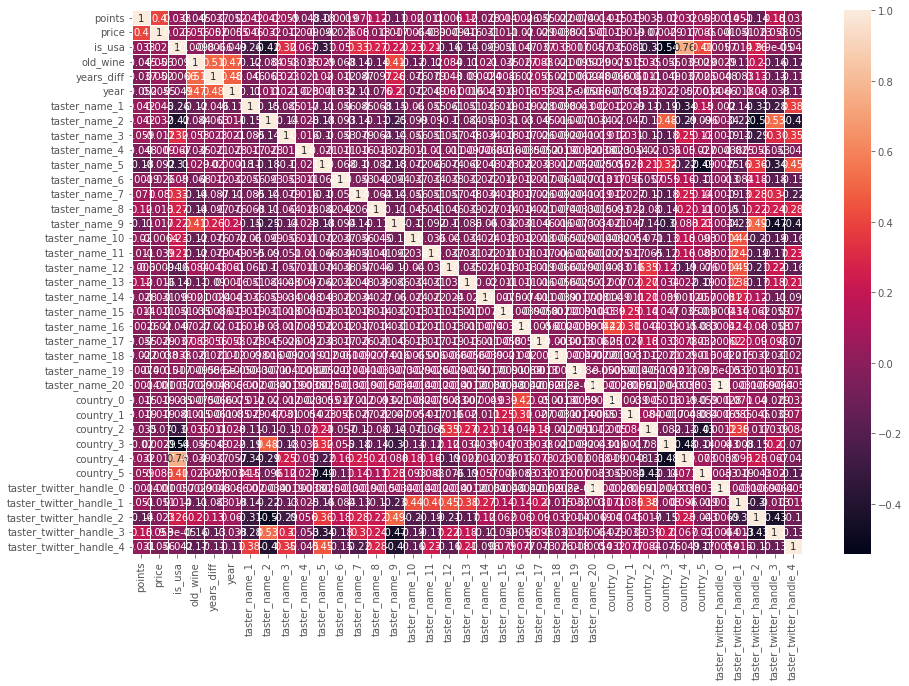

In [161]:
# Удалим самые сильно скоррелированные пары
data = data.drop(['is_france', 'is_italy', 'price_round', 'area'], axis=1)

# Проверяем, что сильно скоррелированных признаков не осталось
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax)

### Проверка знаний 

Датасет болезней сердца содержит информацию о пациентах и переменную предсказания target — наличие у пациента болезни сердца.

Датасет содержит следующие признаки:
* age — возраст
* sex — пол
* cp — тип боли в груди (4 значения)
* trestbps — артериальное давление в покое
* chol — холестерин сыворотки в мг/дл
* fbs — уровень сахара в крови натощак > 120 мг/дл
* restecg — результаты электрокардиографии в покое (значения 0,1,2)
* thalach — достигнута максимальная частота сердечных сокращений
* exang — стенокардия, вызванная физической нагрузкой
* oldpeak — депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя
* slope — наклон пикового сегмента ST при нагрузке
* ca — количество крупных сосудов (0-3), окрашенных при флюроскопии
* thal — дефект, где 3 = нормальный; 6 = фиксированный дефект; 7 = обратимый дефект

Создайте новый признак old, где 1 — при возрасте пациента от 60 лет.

In [53]:
import pandas as pd

heart = pd.read_csv('heart.csv')

heart['old'] = heart['age'].apply(lambda x: 1 if x > 60 else 0)

heart['old'].sum()

79

Создайте новый признак trestbps_mean, который будет обозначать норму давления в среднем для его возраста и пола.

Информацию о среднем давлении для возраста и пола возьмите из этой таблицы.

In [56]:
trestbps = pd.read_csv('trestbps.csv', sep=';')
trestbps.head()

,age,trestbps_sex1,trestbps_sex0
0,20,123,116
1,21,126,120
2,22,126,120
3,23,126,120
4,24,126,120


In [57]:
heart = heart.join(trestbps.set_index('age'), on='age')
heart['trestbps_mean'] = 0

for i in heart.index:
    if heart['sex'][i]==1:
        heart['trestbps_mean'][i] = heart['trestbps_sex1'][i]
    else: 
        heart['trestbps_mean'][i] = heart['trestbps_sex0'][i]

heart = heart.drop(['trestbps_sex1', 'trestbps_sex0'], axis=1)

#heart['trestbps_mean'][300]

C:\Users\User\AppData\Local\Temp/ipykernel_13412/2065859827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart['trestbps_mean'][i] = heart['trestbps_sex1'][i]
C:\Users\User\AppData\Local\Temp/ipykernel_13412/2065859827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart['trestbps_mean'][i] = heart['trestbps_sex0'][i]


Категориальные признаки: sex, cp, fbs, restecg, exang, slope, ca, thal, target

Вышеперечисленные категориальные признаки уже представлены в числовом виде. 

Прикнаки, которые нуждаются в дополнительном кодировании значений: cp, restecg, slope, ca, thal

Раскодируйте вышеперечисленные признаки методом OneHotEncoding без удаления исходных признаков.

In [58]:
# Кодирование признаков
import category_encoders as ce

encoder = ce.OneHotEncoder(cols = ['cp', 'restecg', 'slope', 'ca', 'thal'])
enc_data = encoder.fit_transform(heart[['cp', 'restecg', 'slope', 'ca', 'thal']])
heart = pd.concat([heart, enc_data], axis = 1)

Нормализуйте все числовые признаки подходящим способом.

Для необработанных данных следует использовать RobustScaler.

In [59]:
# для нормализации, стандартизации
from sklearn import preprocessing

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
col_names = list(heart.columns)

# копируем исходный датасет
heart_r = r_scaler.fit_transform(heart)
heart_r = pd.DataFrame(heart_r, columns=col_names)

# смотрим описательные статистики, ответ 0.816232
heart_r.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,slope_3,ca_1,ca_2,ca_3,ca_4,ca_5,thal_1,thal_2,thal_3,thal_4
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,-0.046938,-0.316832,-0.016502,0.081188,0.098646,0.148515,-0.471947,-0.103173,0.326733,0.149752,...,0.462046,-0.422442,0.125413,0.214521,0.066007,0.016502,0.059406,-0.452145,0.386139,0.006601
std,0.672748,0.466011,0.516026,0.876907,0.816232,0.356198,0.525860,0.704774,0.469794,0.725672,...,0.499382,0.494765,0.331734,0.411169,0.248704,0.127605,0.236774,0.498528,0.487668,0.081110
min,-1.925926,-1.000000,-0.500000,-1.800000,-1.795276,0.000000,-1.000000,-2.523077,0.000000,-0.500000,...,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,-0.555556,-1.000000,-0.500000,-0.500000,-0.456693,0.000000,-1.000000,-0.600000,0.000000,-0.500000,...,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.444444,0.000000,0.500000,0.500000,0.543307,0.000000,0.000000,0.400000,1.000000,0.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.629630,0.000000,1.000000,3.500000,5.102362,1.000000,1.000000,1.507692,1.000000,3.375000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000


Проведите корреляционный анализ и отберите признаки для будущей модели. Выберите пары сильно скоррелированных признаков.

<AxesSubplot:>

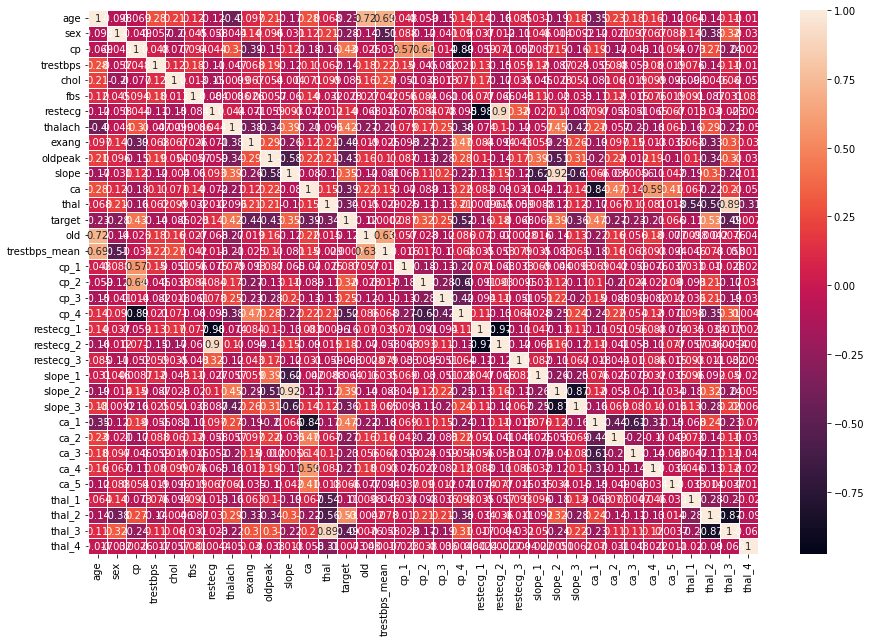

In [60]:
# Отбор признаков 
# Построим график корреляции всех величин. Для простоты воспользуемся корреляцией Пирсона.
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(heart.corr(), annot=True, linewidths=.5, ax=ax)